# Since ARIMA is a univariate model, we don't use features like in XGBoost
# Also, metrics like R-squared are not typically used with ARIMA models

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima
import numpy as np

In [2]:
# Function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero = y_true != 0
    return np.mean(np.abs((y_true[non_zero] - y_pred[non_zero]) / y_true[non_zero])) * 100

In [3]:
df = pd.read_csv('clean_data.csv')  

# Setting the 'Date' as the index after converting it to datetime
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [4]:
# Weekly aggregation of data
weekly_sales = df.resample('W').mean()

C:\Users\Samee\AppData\Local\Temp\ipykernel_11616\3597585398.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  weekly_sales = df.resample('W').mean()


In [5]:
# Differencing the weekly sales data
df_weekly_diff = weekly_sales['Weekly_Sales'].diff().dropna()

In [6]:
# Splitting data into training and testing sets
train_data = df_weekly_diff.iloc[:int(0.7 * len(df_weekly_diff))]
test_data = df_weekly_diff.iloc[int(0.7 * len(df_weekly_diff)):]


 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=1826.858, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=1793.619, Time=0.05 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=1795.532, Time=0.12 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(0,0,5)(0,0,0)[1] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=1804.051, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=1794.966, Time=0.11 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(1,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=1801.215, Time=0.00 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(3,0,0)(0,0,0)[1] intercept   : AIC=1791.045, Tim

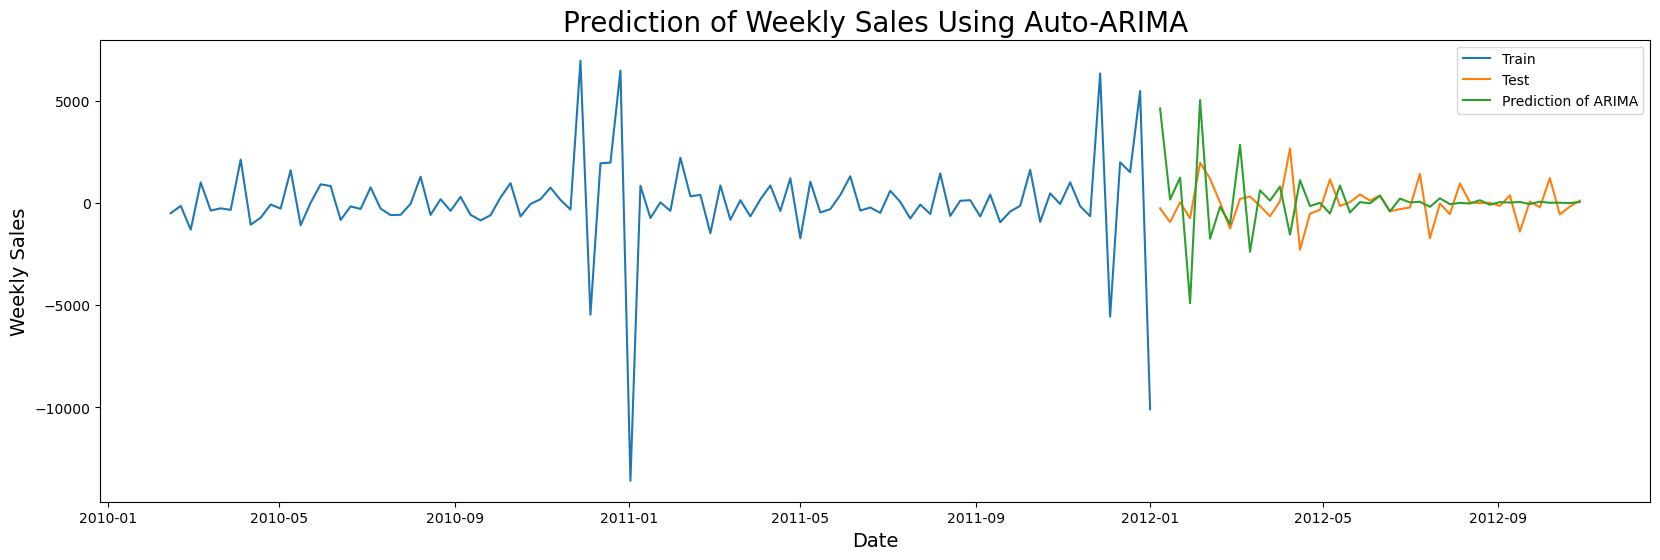

In [7]:
# Fit an Auto-ARIMA model
model_auto_arima = auto_arima(train_data, trace=True, start_p=0, start_q=0, start_P=0, start_Q=0,
                              max_p=20, max_q=20, max_P=20, max_Q=20, seasonal=True, maxiter=200,
                              information_criterion='aic', stepwise=False, suppress_warnings=True, 
                              D=1, max_D=10, error_action='ignore', approximation=False)
model_auto_arima.fit(train_data)

# Predictions
y_pred = model_auto_arima.predict(n_periods=len(test_data))
y_pred = pd.DataFrame(y_pred, index=test_data.index, columns=['Prediction'])

# Plotting
plt.figure(figsize=(20, 6))
plt.title('Prediction of Weekly Sales Using Auto-ARIMA', fontsize=20)
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(y_pred, label='Prediction of ARIMA')
plt.legend(loc='best')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Weekly Sales', fontsize=14)
plt.show()

In [9]:
from sklearn.metrics import mean_squared_error, r2_score  # Add this line

# Calculate and print MSE and R-squared for Auto-ARIMA
mse_arima = mean_squared_error(test_data, y_pred)
r2_arima = r2_score(test_data, y_pred)
print(f"Auto-ARIMA Model: MSE = {mse_arima}, R-squared = {r2_arima}")

Auto-ARIMA Model: MSE = 2827182.18067582, R-squared = -2.588078153231579


In [10]:
# Applying Exponential Smoothing model
model = ExponentialSmoothing(train_data, seasonal='additive', trend='additive', damped_trend=True, seasonal_periods=20).fit()
predictions = model.forecast(len(test_data))


C:\Users\Samee\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [11]:
# Calculating MAE
mae = mean_absolute_percentage_error(test_data, predictions)
print(f'Mean Absolute Error (MAE): {mae}')

# Check for negative predictions
if np.any(predictions < 0):
    print("Warning: Model has predicted negative values, which could indicate issues with the model fit.")

Mean Absolute Error (MAE): 15424.32252778318


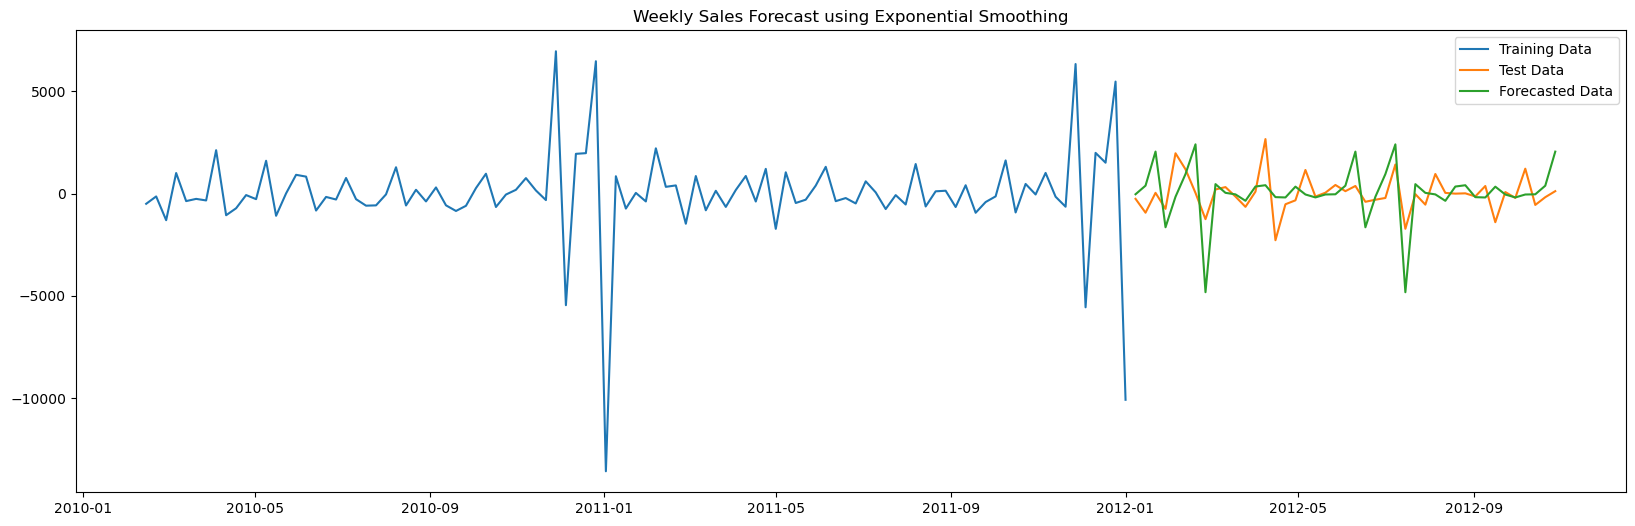

In [12]:
# Plotting the training, testing, and predicted data
plt.figure(figsize=(20, 6))
plt.plot(train_data, label='Training Data')
plt.plot(test_data, label='Test Data')
plt.plot(predictions, label='Forecasted Data')
plt.title('Weekly Sales Forecast using Exponential Smoothing')
plt.legend()
plt.show()


In [13]:
# Calculate and print MSE and R-squared for Exponential Smoothing
mse_exp = mean_squared_error(test_data, predictions)
r2_exp = r2_score(test_data, predictions)
print(f"Exponential Smoothing Model: MSE = {mse_exp}, R-squared = {r2_exp}")

Exponential Smoothing Model: MSE = 1616960.316254969, R-squared = -1.052142244335312
